In [1]:
%matplotlib inline

In [2]:
import torchvision
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from network_class import *
from sequence_dataset import *
from utils import *


In [3]:
# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# set seed
torch.manual_seed(999)

n_classes = 10

cuda


## load test data and model


In [4]:
###############################################################
# IMPORT DATASET 
###############################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 200

traindata = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)

testdata = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)

# data loading 
train_loader = torch.utils.data.DataLoader(traindata, batch_size=batch_size,
                                           shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# check data loading correctness
for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape)
    break


torch.Size([200, 1, 28, 28])


# Define network

In [5]:
###############################################################
# DEFINE NETWORK
###############################################################

# set input and t param

# network hypers
adap_neuron = True  # whether use adaptive neuron or not
dp = 0.4
onetoone = True
num_readout = 10
T = 20

IN_dim = 784
hidden_dim = [256, 784, n_classes * num_readout, 256]

# define network
model = SnnNetwork2Layer(IN_dim, hidden_dim, n_classes, is_adapt=adap_neuron, one_to_one=onetoone,
                   dp_rate=dp)
model.to(device)
print(model)

# define new loss and optimiser 
total_params = count_parameters(model)
print('total param count %i' % total_params)

SnnNetwork2Layer(
  (dp): Dropout(p=0.4, inplace=False)
  (r_in_rec): SnnLayer(
    (rec_w): Linear(in_features=784, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
  (rin2rout): Linear(in_features=784, out_features=256, bias=True)
  (rout2rin): Linear(in_features=256, out_features=784, bias=True)
  (r_out_rec): SnnLayer(
    (rec_w): Linear(in_features=256, out_features=256, bias=True)
    (sigmoid): Sigmoid()
  )
  (output_layer): OutputLayer(
    (sigmoid): Sigmoid()
  )
  (r_in_rec1): SnnLayer(
    (rec_w): Linear(in_features=784, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
  (r_in_rec2): SnnLayer(
    (rec_w): Linear(in_features=256, out_features=256, bias=True)
    (sigmoid): Sigmoid()
  )
  (rin2rout1): Linear(in_features=784, out_features=256, bias=True)
  (rin2rout2): Linear(in_features=256, out_features=100, bias=True)
  (rout2rin1): Linear(in_features=256, out_features=784, bias=True)
  (rout2rin2): Linear(in_features=100, out_features=256, bias=True)

In [6]:
# load model dict
exp_dir = '/home/lucy/spikingPC/results/Feb-28-2023/fptt_ener0_pmean_2layer_alltrainable_nocurr_rm_k20/'
saved_dict = model_result_dict_load(exp_dir + 'onelayer_rec_best.pth.tar')

model.load_state_dict(saved_dict['state_dict'])

<All keys matched successfully>

In [7]:
p2r1 = model.rout2rin1.weight.detach().cpu().numpy()
print(p2r1.shape)

p2r2 = model.rout2rin2.weight.detach().cpu().numpy()
print(p2r2.shape)

topdown = model.top_down.weight.detach().cpu().numpy()
print(topdown.shape)

(784, 256)
(256, 100)
(256, 256)


[0.0, 0.001, 0.0, 0.001, 0.0, 0.001]

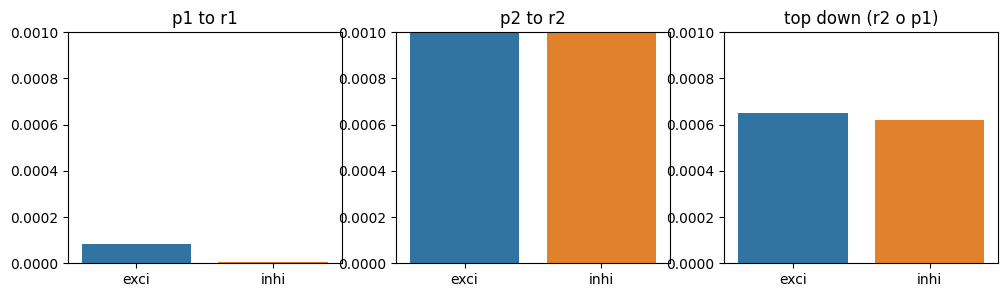

In [8]:
# exci vs inhi strength 
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
x = ['exci', 'inhi']

y = [(p2r1 * (p2r1 > 0)).mean(), -(p2r1 * (p2r1 < 0)).mean()]
sns.barplot(x=x, y=y, ax=axs[0])
axs[0].set_title('p1 to r1')

y = [(p2r2 * (p2r2 > 0)).mean(), -(p2r2 * (p2r2 < 0)).mean()]
sns.barplot(x=x, y=y, ax=axs[1])
axs[1].set_title('p2 to r2')

y = [(topdown * (topdown > 0)).mean(), -(topdown * (topdown < 0)).mean()]
sns.barplot(x=x, y=y, ax=axs[2])
axs[2].set_title('top down (r2 o p1)')

plt.setp(axs, ylim=[0, 0.001])



(256, 784)
(256, 784)


[0.0, 0.005, 0.0, 0.005, 0.0, 0.005]

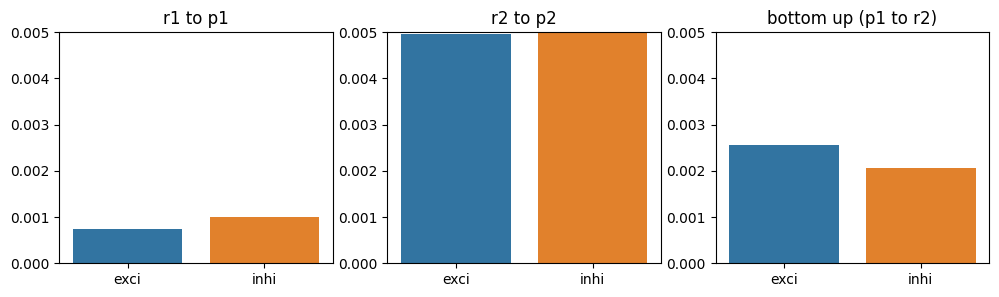

In [9]:
# exci vs inhi strength 
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
x = ['exci', 'inhi']


r2p1 = model.rin2rout1.weight.detach().cpu().numpy()
print(r2p1.shape)

r2p2 = model.rin2rout2.weight.detach().cpu().numpy()
print(r2p1.shape)

bottom_up = model.bottom_up.weight.detach().cpu().numpy()

y = [(r2p1 * (r2p1 > 0)).mean(), -(r2p1 * (r2p1 < 0)).mean()]
sns.barplot(x=x, y=y, ax=axs[0])
axs[0].set_title('r1 to p1')


y = [(r2p2 * (r2p2 > 0)).mean(), -(r2p2 * (r2p2 < 0)).mean()]
sns.barplot(x=x, y=y, ax=axs[1])
axs[1].set_title('r2 to p2')

y = [(bottom_up * (bottom_up > 0)).mean(), -(bottom_up * (bottom_up < 0)).mean()]
sns.barplot(x=x, y=y, ax=axs[2])
axs[2].set_title('bottom up (p1 to r2)')

plt.setp(axs, ylim=[0, 0.005])

(784, 784)
(256, 256)
(256, 256)
(100, 100)


[0.0, 0.007, 0.0, 0.007, 0.0, 0.007, 0.0, 0.007]

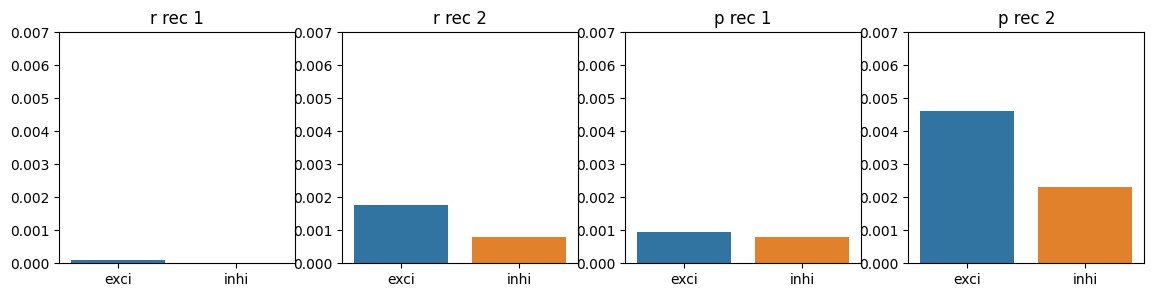

In [10]:
# exci vs inhi strength 
fig, axs = plt.subplots(1, 4, figsize=(14, 3), sharex=True)
x = ['exci', 'inhi']

r_rec1 = model.r_in_rec1.rec_w.weight.detach().cpu().numpy()
print(r_rec1.shape)

r_rec2 = model.r_in_rec2.rec_w.weight.detach().cpu().numpy()
print(r_rec2.shape)

p_rec1 = model.r_out_rec1.rec_w.weight.detach().cpu().numpy()
print(p_rec1.shape)

p_rec2 = model.r_out_rec2.rec_w.weight.detach().cpu().numpy()
print(p_rec2.shape)

y = [(r_rec1 * (r_rec1 > 0)).mean(), -(r_rec1 * (r_rec1 < 0)).mean()]
sns.barplot(x=x, y=y, ax=axs[0])
axs[0].set_title('r rec 1')


y = [(r_rec2 * (r_rec2 > 0)).mean(), -(r_rec2 * (r_rec2 < 0)).mean()]
sns.barplot(x=x, y=y, ax=axs[1])
axs[1].set_title('r rec 2')

y = [(p_rec1 * (p_rec1 > 0)).mean(), -(p_rec1 * (p_rec1 < 0)).mean()]
sns.barplot(x=x, y=y, ax=axs[2])
axs[2].set_title('p rec 1')


y = [(p_rec2 * (p_rec2 > 0)).mean(), -(p_rec2 * (p_rec2 < 0)).mean()]
sns.barplot(x=x, y=y, ax=axs[3])
axs[3].set_title('p rec 2')

plt.setp(axs, ylim=[0, 0.007])

In [11]:
# skip = model.skip.weight.detach().cpu().numpy()
# print(skip.shape)

# y = [(skip * (skip > 0)).sum(), -(skip * (skip < 0)).sum()]
# sns.barplot(x=x, y=y)
# plt.title('r1 to r2')

Text(0.5, 1.0, 'r_out weights to r_in by class')

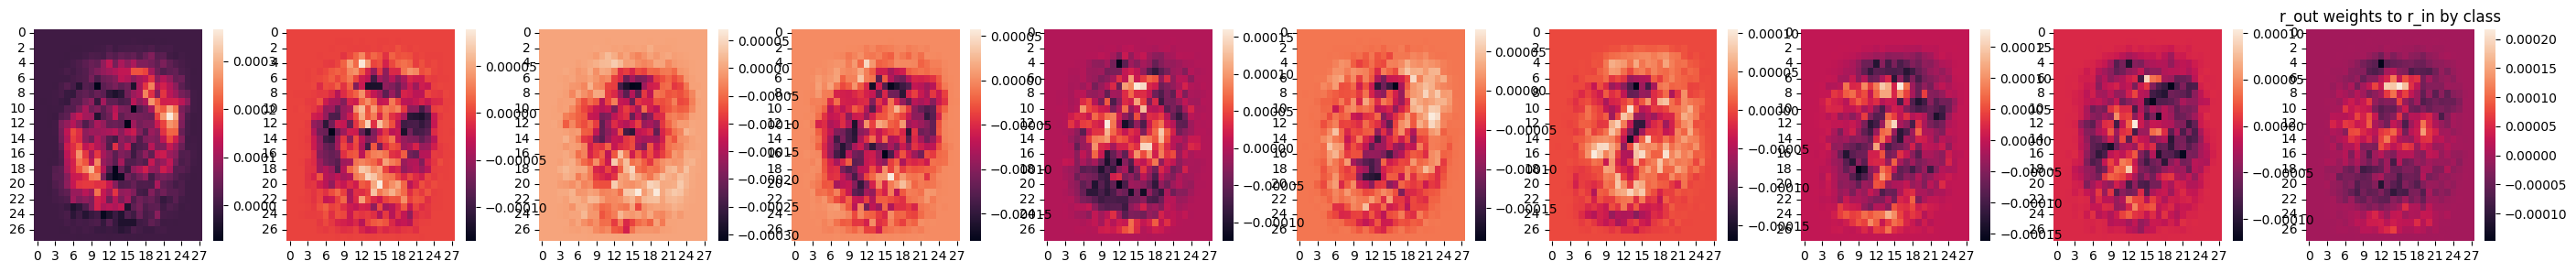

In [12]:
# plot p to r weights
fig, axs = plt.subplots(1, n_classes, figsize=(35, 3))
for i in range(n_classes):
    composite_topdownw = p2r1 @ topdown @ p2r2[:, num_readout * i:(i + 1) * num_readout]
    sns.heatmap(composite_topdownw.sum(axis=1).reshape(28, 28),
                ax=axs[i])
plt.title('r_out weights to r_in by class')

# plt.show()

In [13]:
hidden_all, preds_all, data_all, _ = get_all_analysis_data(model, test_loader, device, IN_dim, T)


Test set: Average loss: 0.2069, Accuracy: 9656/10000 (97%)



In [14]:
r1_spk = get_states(hidden_all, 1, hidden_dim[1], batch_size) 
p1_spk = get_states(hidden_all, 5, hidden_dim[0], batch_size)

r2_spk = get_states(hidden_all, 9, hidden_dim[3], batch_size) 
p2_spk = get_states(hidden_all, 13, hidden_dim[2], batch_size)

In [15]:
r1_spk.shape

(10000, 20, 784)

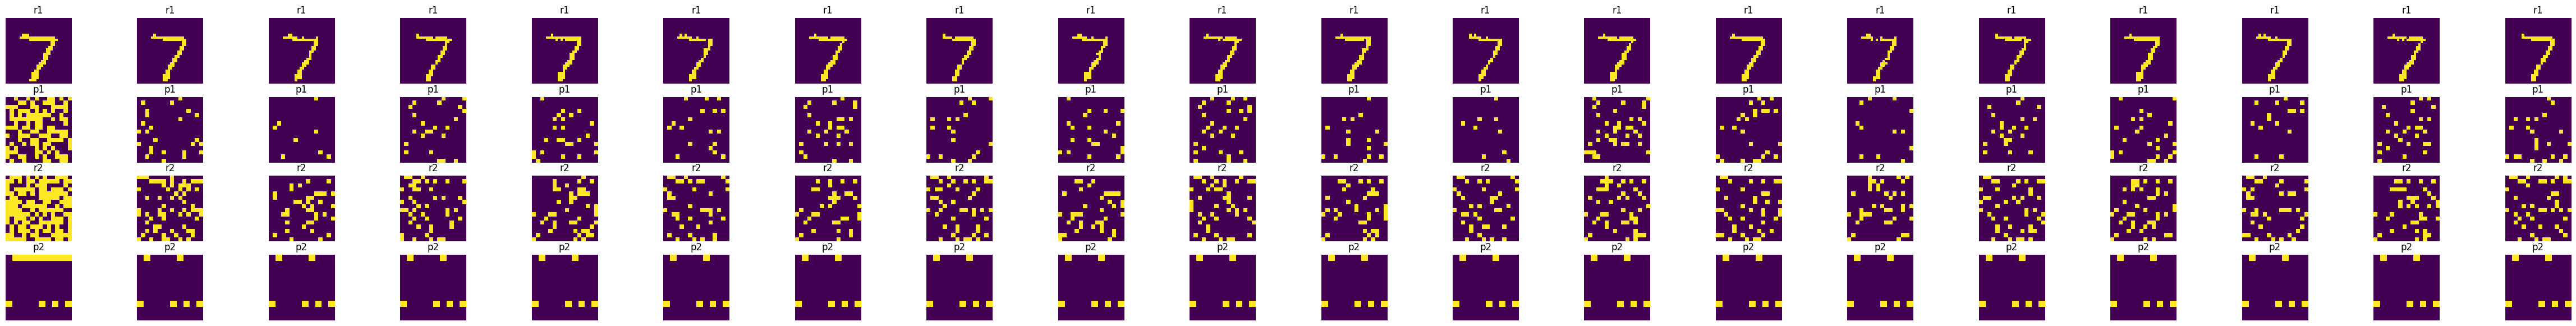

In [16]:
sample_no = 0

# plot spiking
fig, axs = plt.subplots(4, 20, figsize=(60, 7))
for i in range(T):
    axs[0][i].imshow(r1_spk[sample_no, i, :].reshape(28, 28))
    axs[0][i].set_title('r1')
    axs[0][i].axis('off')

    axs[1][i].imshow(p1_spk[sample_no, i, :].reshape(16, 16))
    axs[1][i].set_title('p1')
    axs[1][i].axis('off')

    axs[2][i].imshow(r2_spk[sample_no, i, :].reshape(16, 16))
    axs[2][i].set_title('r2')
    axs[2][i].axis('off')

    axs[3][i].imshow(p2_spk[sample_no, i, :].reshape(10, 10))
    axs[3][i].set_title('p2')
    axs[3][i].axis('off')


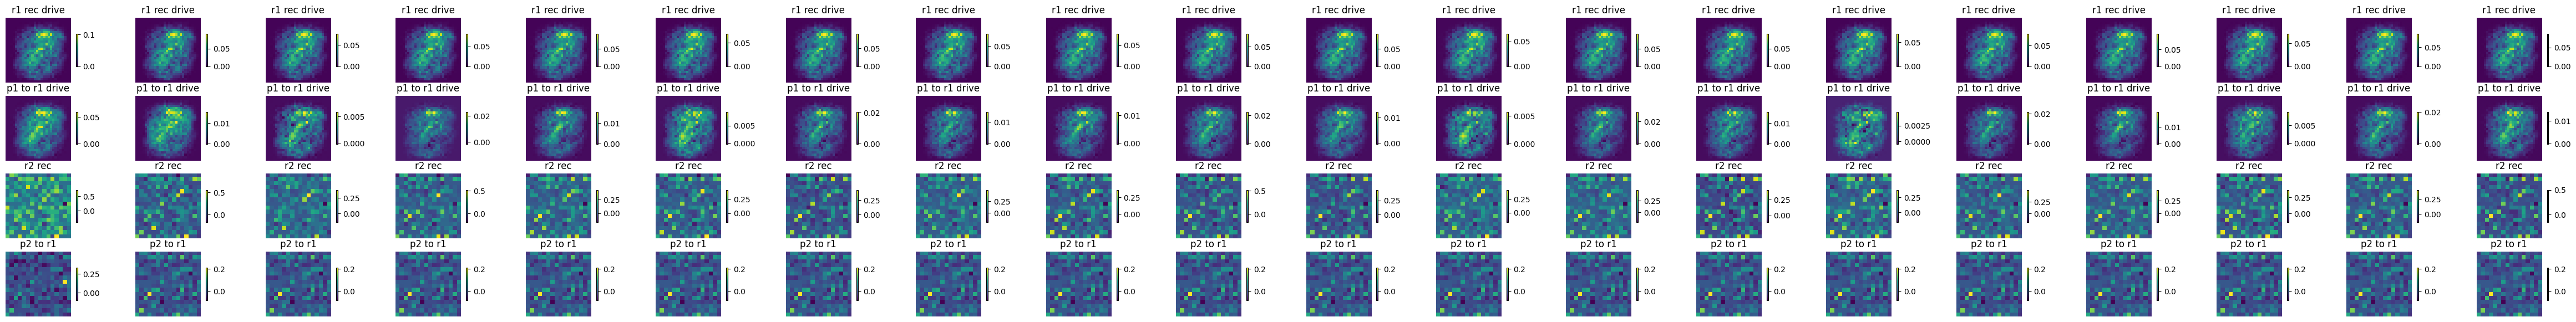

In [17]:
# plot projectiosn 
fig, axs = plt.subplots(4, 20, figsize=(60, 7))
for i in range(T):
    pos1 = axs[0][i].imshow((r_rec1 @ r1_spk[sample_no, i, :]).reshape(28, 28))
    axs[0][i].set_title('r1 rec drive')
    fig.colorbar(pos1, ax=axs[0][i], shrink=0.5)
    axs[0][i].axis('off')

    pos2 = axs[1][i].imshow((p2r1 @ p1_spk[sample_no, i, :]).reshape(28, 28))
    fig.colorbar(pos2, ax=axs[1][i], shrink=0.5)
    axs[1][i].set_title('p1 to r1 drive')
    axs[1][i].axis('off')

    pos3 = axs[2][i].imshow((r_rec2 @ r2_spk[sample_no, i, :]).reshape(16, 16))
    fig.colorbar(pos3, ax=axs[2][i], shrink=0.5)
    axs[2][i].set_title('r2 rec')
    axs[2][i].axis('off')

    pos4 = axs[3][i].imshow((p2r2 @ p2_spk[sample_no, i, :]).reshape(16, 16))
    fig.colorbar(pos4, ax=axs[3][i], shrink=0.5)
    axs[3][i].set_title('p2 to r1')
    axs[3][i].axis('off')

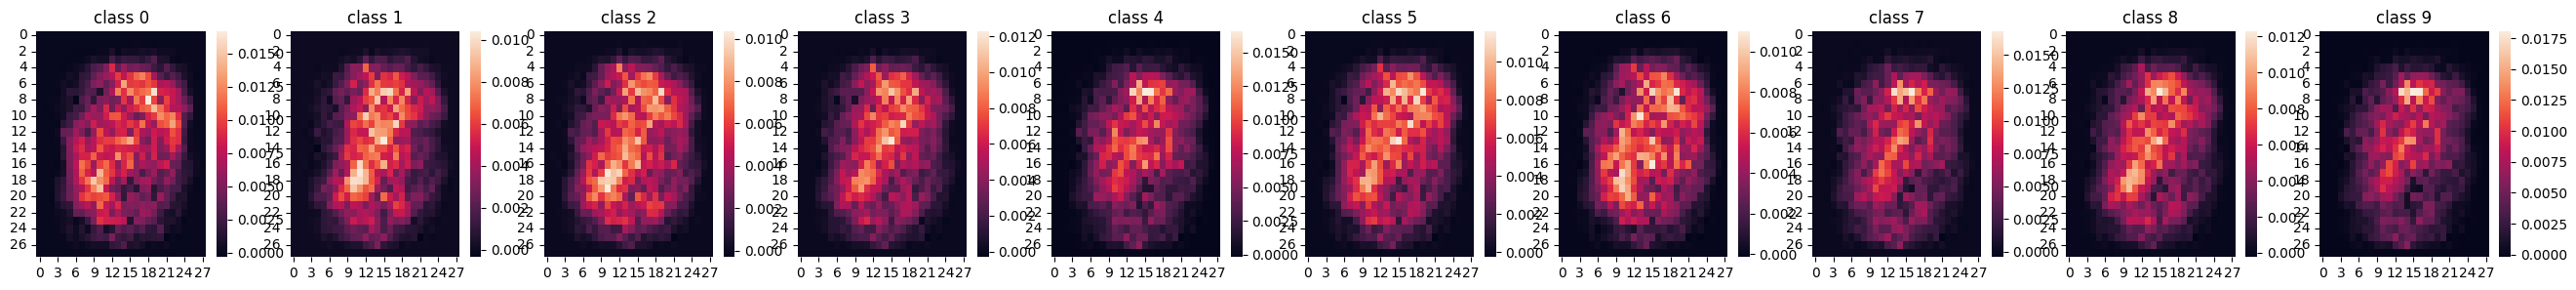

In [18]:
# spk mean per class 
targets_all = testdata.targets

fig, axs = plt.subplots(1, 10, figsize=(33, 3))
for i in range(n_classes):
    sns.heatmap((p2r1 @ p1_spk[targets_all==i].mean(axis=0).mean(axis=0)).reshape(28, 28), ax=axs[i])
    axs[i].set_title('class %i' %i)

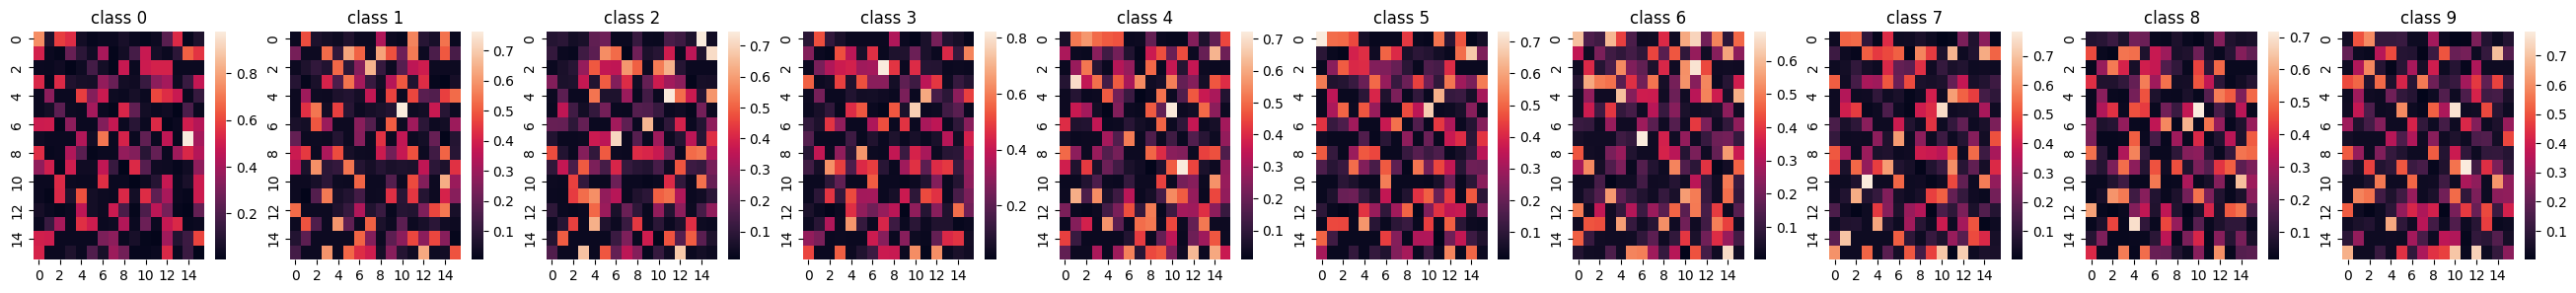

In [19]:
# r2 spk 
fig, axs = plt.subplots(1, 10, figsize=(33, 3))
for i in range(n_classes):
    sns.heatmap(( r2_spk[targets_all==i].mean(axis=0).mean(axis=0)).reshape(16, 16), ax=axs[i])
    axs[i].set_title('class %i' %i)

Text(0.5, 1.0, 'RDA r2 spk vs p2 to r2 projection')

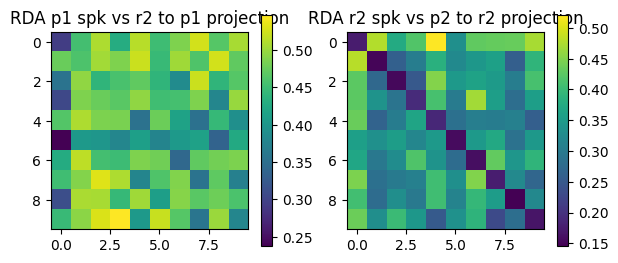

In [20]:
# r2 to p1 projection vs p1 RSA 
from sklearn.metrics import pairwise_distances

p1_rep_byclass = []
r2_to_p1_byclass = []

r2_rep_byclass = []
p2_to_r2_byclass = []

for i in range(n_classes):
    p1_rep_byclass.append(p1_spk[targets_all==i].mean(axis=0).mean(axis=0))
    r2_to_p1_byclass.append(np.abs(topdown @ (r2_spk[targets_all==i].mean(axis=0).mean(axis=0))))

    r2_rep_byclass.append(r2_spk[targets_all==i].mean(axis=0).mean(axis=0))
    p2_to_r2_byclass.append(np.abs(p2r2 @ (p2_spk[targets_all==i].mean(axis=0).mean(axis=0))))

p1_rep_byclass = np.stack(p1_rep_byclass)
r2_to_p1_byclass = np.stack(r2_to_p1_byclass)

r2_rep_byclass = np.stack(r2_rep_byclass)
p2_to_r2_byclass = np.stack(p2_to_r2_byclass)

pair_dist1 = pairwise_distances(p1_rep_byclass, r2_to_p1_byclass, metric='cosine')
pair_dist2 = pairwise_distances(r2_rep_byclass, p2_to_r2_byclass, metric='cosine')

fig, ax = plt.subplots(1, 2, figsize=(7, 3))
pos1 = ax[0].imshow(pair_dist1)
fig.colorbar(pos1, ax=ax[0])
ax[0].set_title('RDA p1 spk vs r2 to p1 projection')

pos2 = ax[1].imshow(pair_dist2)
fig.colorbar(pos2, ax=ax[1])
ax[1].set_title('RDA r2 spk vs p2 to r2 projection')


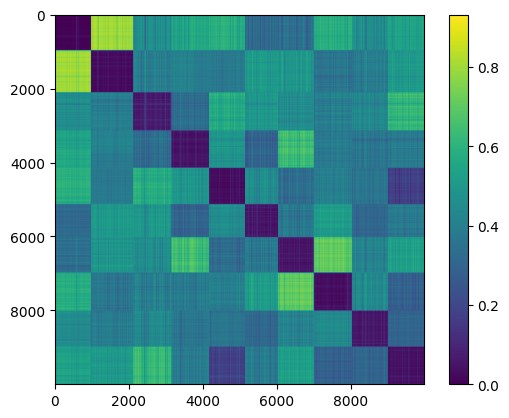

In [21]:
sorted_label, indices = torch.sort(targets_all)
pair_dist = pairwise_distances((r2_spk.mean(axis=1)[indices]) @ topdown.T, metric='cosine')

fig, ax = plt.subplots()
im = plt.imshow(pair_dist)
fig.colorbar(im, ax=ax)

In [22]:
pair_dist.shape

(10000, 10000)

In [23]:
# compare disentanglement with representation in each layer at t=0

reps = [r1_spk, p1_spk, r2_spk, p2_spk]
ws = [p2r1, topdown, p2r2]
accs = []
accs_proj = []

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def fit_model(x_data):
    X_train, X_test, y_train, y_test = train_test_split(x_data, targets_all.numpy(), test_size=0.2, random_state=99)

    reg = LogisticRegression(max_iter=400).fit(X_train, y_train)

    acc = reg.score(X_test, y_test)

    return acc

for i in range(len(reps)):
    rep_ = reps[i].mean(axis=1)
    acc1 = fit_model(rep_)
    accs.append(acc1)

    if i > 0:
        projection_ = rep_ @ ws[i-1].T
        acc2 = fit_model(projection_)
        accs_proj.append(acc2)

    

Text(0.5, 1.0, 'decodability of spk representations vs top down inhibition')

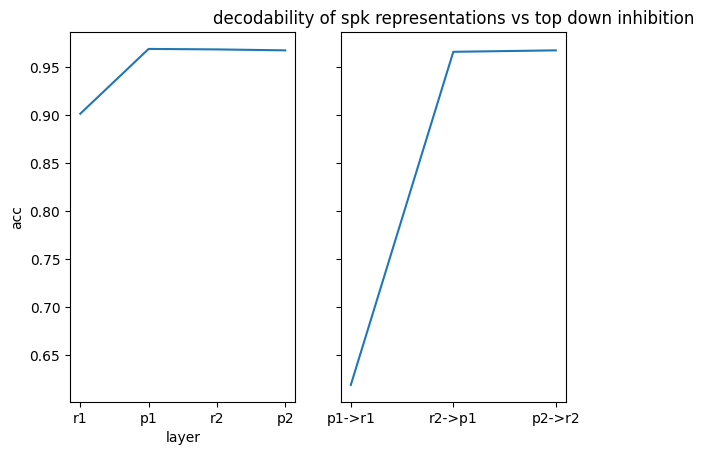

In [24]:
df = pd.DataFrame()
df['acc'] = accs
df['layer'] = ['r1', 'p1', 'r2', 'p2']

fig, axs = plt.subplots(1, 2, sharey=True)
sns.lineplot(df, x='layer', y='acc', ax=axs[0])
sns.lineplot(x=['p1->r1', 'r2->p1', 'p2->r2'], y=accs_proj, ax=axs[1])
plt.title('decodability of spk representations vs top down inhibition')
